In [4]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from Bio import SeqIO
from collections import Counter

In [5]:
dfabundance = pd.read_csv('Data/abundance', header=0, index_col=0, sep='\t')

In [6]:
taxa = dfabundance["taxonomy"].str.split(";", expand=True).iloc[:,0:7]
taxa.columns = ["domain","phylum","class","order","family","genus","species"]
taxa.replace('', np.nan, inplace=True)
taxa.fillna("None", inplace=True)

dfabundance_tax = pd.concat([dfabundance, taxa], axis=1, sort=False)

# OTU analysis result

In [7]:
with open('Data/result_uc95_list', "w") as output:
    with open('Data/result_95.fasta', "r") as f:
        for record in SeqIO.parse(f, "fasta"):
            output.write(record.id + "\n")

In [8]:
dfuc95 = pd.read_csv('Data/result_uc95_list', header=None, sep="|", usecols=[0,2], index_col=1, names=["clst", "accid"])
print(len(dfuc95))

1198


In [9]:
dfabundance_tax_clst = pd.concat([dfuc95, dfabundance_tax], axis=1, sort=False)
print(len(dfabundance_tax_clst))
dfabundance_tax_clst.to_csv('Data/abundance_otu', sep='\t')

1198


In [10]:
dfabundance_tax_clst.head()

,clst,insitu1,insitu2,insitu3,insitu4,insitu5,insitu6,onboard1,onboard2,onboard3,...,onboard7,taxonomy,taxonomy2,domain,phylum,class,order,family,genus,species
AB902090.1.2169,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000065,NaN,...,NaN,Eukaryota;Excavata;Discoba;Discicristata;Eugle...,uncultured eukaryote,Eukaryota,Excavata,Discoba,Discicristata,Euglenozoa,Euglenida,Heteronematina
AF080225.1.2027,1,NaN,0.000036,NaN,NaN,NaN,NaN,0.000061,NaN,0.000052,...,NaN,Eukaryota;Excavata;Discoba;Discicristata;Eugle...,Cryptobia salmositica,Eukaryota,Excavata,Discoba,Discicristata,Euglenozoa,Kinetoplastea,Metakinetoplastina
KF182482.1.1894,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Eukaryota;Opisthokonta;Holozoa;Metazoa (Animal...,Areopaguristes hewatti,Eukaryota,Opisthokonta,Holozoa,Metazoa (Animalia),Eumetazoa,Bilateria,Arthropoda
KC012487.4247.6127,3,NaN,NaN,NaN,NaN,0.000037,NaN,NaN,NaN,0.000026,...,NaN,Eukaryota;Opisthokonta;Holozoa;Metazoa (Animal...,Eumunida picta,Eukaryota,Opisthokonta,Holozoa,Metazoa (Animalia),Eumetazoa,Bilateria,Arthropoda
KF182479.1.1865,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000065,0.000026,...,NaN,Eukaryota;Opisthokonta;Holozoa;Metazoa (Animal...,Munidopsis erinacea,Eukaryota,Opisthokonta,Holozoa,Metazoa (Animalia),Eumetazoa,Bilateria,Arthropoda


# Abundance at OTU level

In [11]:
def Minimum_any(df, minimum, colname):
    
    # > minimum in at least one sample

    tmp = df.where(df >= minimum).dropna(how='all')
    df_tmp = pd.concat([tmp, df], axis=1, join_axes=[tmp.index])
    df_high = df_tmp.iloc[:,13:26]

    tmp = df.where(df < minimum).dropna(how='any')
    df_tmp = pd.concat([tmp, df], axis=1, join_axes=[tmp.index])
    df_low = df_tmp.iloc[:,13:26]

    df_high.loc[colname] = df_low.sum()

    return df_high

In [12]:
taxalist = ["Thiotrichales", "Methylococcales", "Campylobacterales"]
italics =  ['$\it{In}$ $\it{situ}$ total RNA 1', '$\it{In}$ $\it{situ}$ total RNA 2', '$\it{In}$ $\it{situ}$ total RNA 3', '$\it{In}$ $\it{situ}$ total RNA 4', '$\it{In}$ $\it{situ}$ total RNA 5',
       '$\it{In}$ $\it{situ}$ total RNA 6', 'Onboard total RNA 1', 'Onboard total RNA 2', 'Onboard total RNA 3',
       'Onboard total RNA 4', 'Onboard total RNA 5', 'Onboard total RNA 6', 'Onboard total RNA 7']


def Dominant_OTU(df, taxa):
    dftaxa = df[df['order'] == taxa]
    dfclst = dftaxa.groupby('clst').sum()
    
    dfclst['clst'] = "OTU " + dfclst.index.astype(str)
    dfclst.set_index('clst', inplace=True)
    print(taxa, '#clster:', len(dfclst))
        
    dftmp = Minimum_any(dfclst, 0.01, '< 0.01')
    dftmp2 = dftmp.iloc[:-1,].sort_values(list(dftmp.columns), ascending=False)
    
    dftmpout = pd.concat([dftmp2, dftmp.iloc[-1:,]]) # reverse index
    
    dftmpout.columns=italics
    dftmpout = dftmpout[dftmpout.columns[::-1]] # reverse columns
    
    return dftmpout.T


In [13]:
df0 = Dominant_OTU(dfabundance_tax_clst, taxalist[0])
df1 = Dominant_OTU(dfabundance_tax_clst, taxalist[1])
df2 = Dominant_OTU(dfabundance_tax_clst, taxalist[2])

Thiotrichales #clster: 82
Methylococcales #clster: 44
Campylobacterales #clster: 85


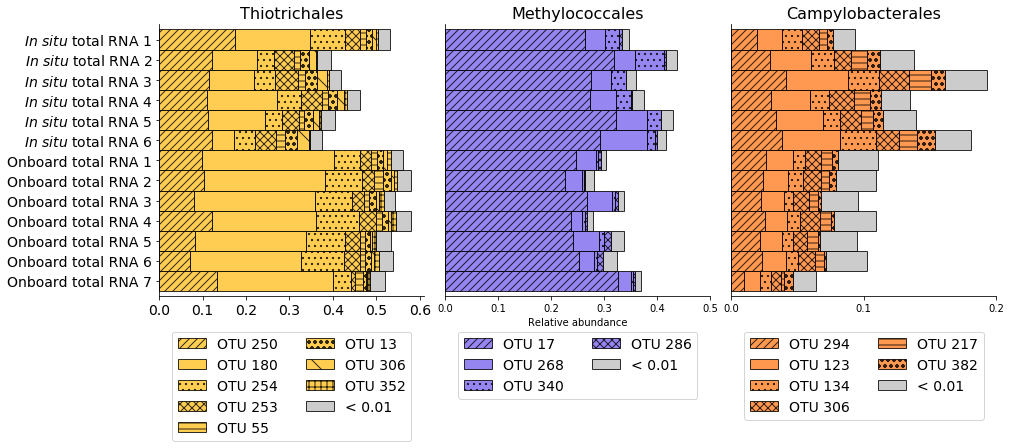

In [14]:
fig = plt.figure(figsize=(15, 5))
plt.subplots_adjust(wspace=0.08)

ax0 = fig.add_subplot(131)
ax1 = fig.add_subplot(132, xlabel="Relative abundance", xlim=(0,0.5))
ax2 = fig.add_subplot(133, xlim=(0,0.2), xticks=[0, 0.1, 0.2])


col = ['#ffc125', '#ffc125', '#ffc125','#ffc125', '#ffc125', '#ffc125','#ffc125', '#ffc125', 'silver']
hatches = ["///", "", "..", "xxx", "--", "oo", "\\", "++", ""]

df0.plot.barh(ax=ax0, stacked=True, width=1, 
                  color=col, edgecolor="k", alpha=0.8, fontsize=14)
patches = ax0.patches
for i, patch in enumerate(patches):
    patch.set_hatch(hatches[i//len(df0.index)])

    
col = ['#7b68ee', '#7b68ee', '#7b68ee', '#7b68ee', 'silver']
hatches = ["///", "", "..", "xxx", ""]

df1.plot.barh(ax=ax1, stacked=True, width=1,
                  color=col, edgecolor="k", alpha=0.8)
patches = ax1.patches
for i, patch in enumerate(patches):
    patch.set_hatch(hatches[i//len(df0.index)])

    
col = ['#ff7f24', '#ff7f24', '#ff7f24','#ff7f24', '#ff7f24', '#ff7f24', 'silver']
hatches = ["///", "", "..", "xxx", "--", "oo", "", ""]

df2.plot.barh(ax=ax2, stacked=True, width=1, 
                  color=col, edgecolor="k", alpha=0.8)
patches = ax2.patches
for i, patch in enumerate(patches):
    patch.set_hatch(hatches[i//len(df0.index)])

# title
ax0.set_title(taxalist[0], fontsize=16)
ax1.set_title(taxalist[1], fontsize=16)
ax2.set_title(taxalist[2], fontsize=16)

# legend
ax0.legend(bbox_to_anchor=(0.5, -0.13), loc="upper center", borderaxespad=0, 
           ncol=2, fontsize=14)
ax1.legend(bbox_to_anchor=(0.5, -0.13), loc="upper center", borderaxespad=0, 
           ncol=2, fontsize=14)
ax2.legend(bbox_to_anchor=(0.5, -0.13), loc="upper center", borderaxespad=0, 
           ncol=2, fontsize=14)

# remove label of y axis
ax1.tick_params(axis='y', labelleft=False, left=False) 
ax2.tick_params(axis='y', labelleft=False, left=False) 

# remove spines
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

fig.show()
fig.savefig('Figures/Fig2.pdf', bbox_inches='tight')